<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [ ]:
%%capture
pip install pyswarms

In [ ]:
%%capture
pip install scipy

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps

In [ ]:
!dpkg-reconfigure locales

In [ ]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

In [ ]:
print(locale.getlocale())

In [ ]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4179]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'pso'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'quarto_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = 'tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [4180]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_quarto_cenario/


In [4153]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [4154]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [4155]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [4156]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [4157]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [4158]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [4159]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [4160]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 400.0000}
    custos = [dist.get(si, CMP) for si in s]
    custo_total = np.sum(custos)
    return custo_total

In [4161]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.5: 2000, 1.0: 3000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.20 or si > 1.0 else np.interp(si, [0.5, 1.0], [2000, 3000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [4181]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [4172]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [4173]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [4199]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-12-28 20:25:58,515 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0852
2023-12-28 20:25:58,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08518941147102879, best pos: [149.93410135   1.00276098   0.52506503]


In [4200]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 149.93410134879807
beta: 1.002760981332281
theta: 0.5250650279842559

Tempo de Convergência para a primeira etapa: 0.00826573371887207 segundos


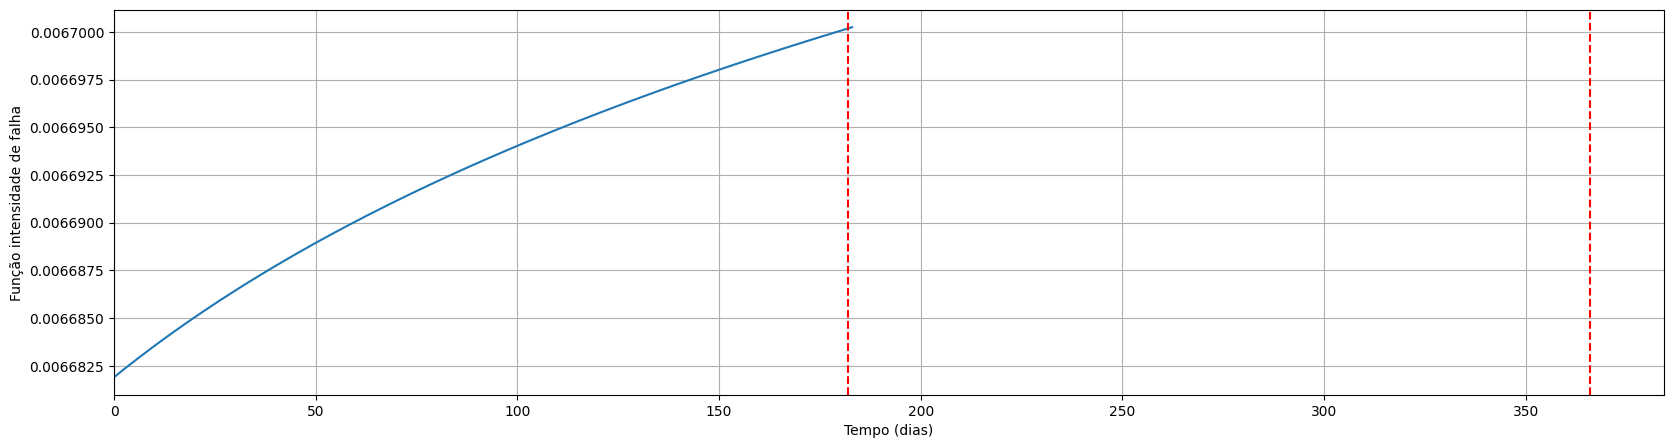

Fator ajuste:  [0.4084831020353956, 0.4084831020353956, 0.4084831020353956, 0.4084831020353956, 0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.4084831020353956, 0.23089864259344572, 0.4084831020353956, 0.23089864259344572, 0.4084831020353956, 0.4084831020353956, 0.4084831020353956]


In [4201]:
# lamb = 148.8236099092524
# beta = 1.003177327961337
# theta = 0.6594169622308468

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [4202]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'

In [4203]:
# Gravar os valores de Lambda, Beta e Theta em um arquivo separado
melhores_parametros = []

try:
    with open(nome_arquivo_parametros, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_parametros.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução


# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [4204]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,148.378437,1.000280,0.443913,0.014879
1,1,148.378437,1.000280,0.443913,0.014879
2,2,149.934101,1.002761,0.525065,0.008266


In [4205]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,3.0,3.000000,3.000000,3.000000,3.000000
mean,1.0,148.896992,1.001107,0.470964,0.012674
std,1.0,0.898163,0.001432,0.046853,0.003818
min,0.0,148.378437,1.000280,0.443913,0.008266
25%,0.5,148.378437,1.000280,0.443913,0.011572
50%,1.0,148.378437,1.000280,0.443913,0.014879
75%,1.5,149.156269,1.001521,0.484489,0.014879
max,2.0,149.934101,1.002761,0.525065,0.014879


In [4206]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

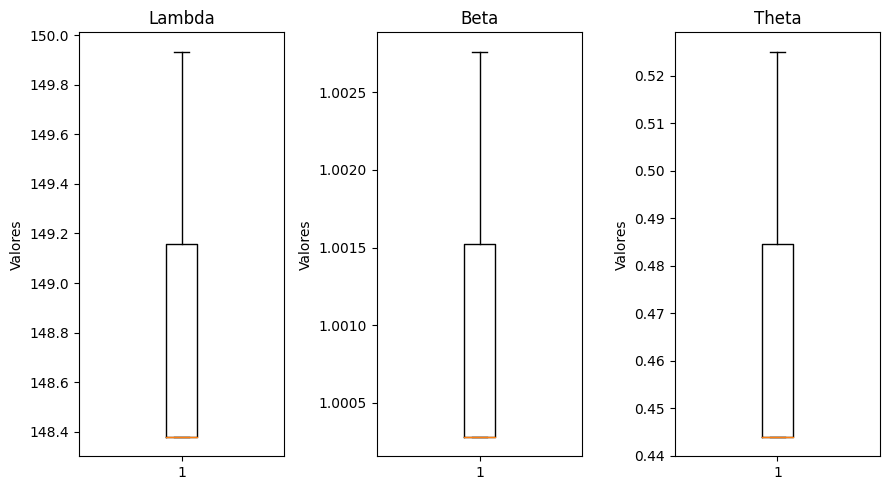

In [4207]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [4208]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [4210]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.5, 3:0, 5:0, 7:1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [4211]:
num_particles = 100
max_iterations = 100
dimensions = VALOR_DIMENSOES
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-12-28 20:32:36,013 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=365



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 33, 92, 454, 480, 600]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2191787708459561, 0.612481316295159, 3.0363122243536713, 3.2106243474573843, 4.015512156773182, 4.887967740382168]
Custo =  810.9010700397998


Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 60, 212, 277, 302, 330, 601]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.3991651813665747, 1.4146557486018305, 1.8496898560619215, 2.017078500861929, 2.2045992838203796, 4.021726527920884, 4.887472236040096]
Custo =  95

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=365



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 63, 124, 275, 450, 542, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.41917990382528364, 0.8262146766405032, 1.836372533917211, 3.0089598811862244, 3.6258882837421416, 4.61894992414922, 4.887432858201549]
Custo =  877.12410840651


Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 37, 91, 211, 424, 454, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.24582353425034179, 0.6058045695059773, 1.4079656660930784, 2.8347016928701976, 3.035797719607739,

pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=257



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 64, 573, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.42585206912938217, 3.8346885403942466, 4.633208522057922, 4.888268012665399]
Custo =  506.21868096529334


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 122, 428, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8132277500166314, 2.861545786895646, 4.632598356748709, 4.887657847356185]
Custo =  484.8408570038388


Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 30, 691]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de f

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=254



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 61, 271, 544, 661]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.40583645516323336, 1.8096431232875916, 3.639536783561544, 4.4245325236513615, 4.887646755651801]
Custo =  597.645075095113


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 125, 543, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8332810413829073, 3.632915198457459, 4.451465499626899, 4.887735009804705]
Custo =  469.72543766167587


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 31, 61, 212, 578, 661]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fa

pyswarms.single.global_best:  70%|███████   |70/100, best_cost=254<ipython-input-4210-589f9e28a1de>:79: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=254



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 31, 122, 278, 426]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.20585967091967328, 0.8128649839774093, 1.8564820412340741, 2.8480607716744797, 4.887657334444673]
Custo =  620.5560902963202


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 31, 213, 395]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.20585967091967328, 1.4215033249450961, 2.6404308419034446, 4.88787503492544]
Custo =  493.3571181252735


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 31, 66, 424, 457]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0

pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=254

 [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2191787708459561, 0.452331215905704, 1.0267236878054393, 2.620292628982717, 2.8414553356763785, 4.6191960720882985, 4.887679006140628]
Custo =  969.5667021600859


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 152, 213, 694]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2191787708459561, 1.0133896169186336, 1.4213310194923507, 4.646496416286889, 4.888132388001754]
Custo =  671.2225511313734


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 31, 183, 397, 425, 695]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=254
2023-12-28 20:32:37,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10490165 1.20995291 0.71575817 0.76505895 0.06474033 1.19223927
 0.52820532 0.6957735  0.75696474 0.70911266 0.05949896 1.03741616
 0.58262209 1.20547566 0.36596107 1.08946675 1.23574534 0.59626244
 0.62323766 0.22976116 0.92138463 0.71003274 0.29081786 0.56893449]
2023-12-28 20:32:37,274 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  499.86918563168393


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10466883 0.36945603 0.71154562 0.76432591 0.729063   1.17920558
 1.00390144 0.60344675 0.75688219 0.71229806 0.44535494 1.03763999
 0.87421233 0.48746408 0.36595845 1.08944669 1.23574894 0.5027343
 0.55236162 0.22932886 0.92857638 0.62311539 0.28231381 0.78506602]
2023-12-28 20:32:37,286 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 34, 127]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.22583916546214514, 0.8462668182832135, 4.888740433760894]
Custo =  383.9086027030377


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10532407 0.03860774 0.70984416 0.76426392 0.02836657 1.18618107
 0.38787593 0.67209469 0.75697081 0.70604057 0.71718832 1.03266602
 0.76218286 1.10658405 0.36594805 1.08943575 1.23574934 0.54957499
 0.53612642 0.229445   0.91906007 0.60798193 0.28541668 0.75280824]
2023-12-28 20:32:37,299 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 37, 690]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.24582353425034179, 4.620578321851256, 4.889061255903585]
Custo =  407.9482011802069


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10581524 0.7880527  0.7090308  0.76421263 0.82823328 1.19288253
 1.13543916 0.7374217  0.7570494  0.70074059 1.04209892 1.02939549
 0.61875016 0.2339591  0.36594081 1.08943289 1.23574913 0.59421854
 0.53402856 0.22960077 0.91063245 0.62098733 0.28871829 0.71845732]
2023-12-28 20:32:37,312 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 154, 273, 306, 397, 427, 451, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.0271937855267768, 1.823016892452646, 2.0439721692827773, 2.65362932529825, 2.8546904571516887, 3.015566426672942, 4.6323942614970335, 4.88745375210451]
Custo =  1126.9923492945527


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,324 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10624981 0.11761599 0.70999451 0.76436605 0.45930216 1.19889191
 0.55773545 0.79321819 0.75709701 0.6979969  0.23762213 1.02673086
 0.48074279 0.61630122 0.36593923 1.08943792 1.23574886 0.63485513
 0.54547247 0.22976963 0.90489619 0.65376426 0.29189143 0.68405806]
2023-12-28 20:32:37,325 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 5, 62, 157, 394, 455, 572, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.03303633079108191, 0.41240531427191435, 1.046891139601279, 2.633802673321754, 3.042671371231739, 3.8273293820371914, 4.625845955029256, 4.887617176805328]
Custo =  1384.5844450582222


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,336 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.1066192  0.73551609 0.71205556 0.76463378 0.16113211 1.20357382
 0.03625504 0.82287503 0.75713722 0.69767878 0.92689821 1.0257815
 0.37448143 0.96855594 0.3659432  1.08944586 1.23574837 0.66653272
 0.56077482 0.22992111 0.90310766 0.69564185 0.29470889 0.6449229 ]
2023-12-28 20:32:37,338 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 181, 391, 420, 458, 485]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2078247977565957, 2.6134808892927954, 2.8078313533379013, 3.062554754036015, 3.2435760945724135, 4.887508888881668]
Custo =  827.1991239962508


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10692491 1.20335135 0.71436474 0.76487858 0.01407141 1.20450093
 0.93991304 0.83948026 0.75716005 0.70043279 0.37175983 1.02666531
 0.30149232 1.22569971 0.36595002 1.08945522 1.23574738 0.678843
 0.58946671 0.23001627 0.90687827 0.73410613 0.29617528 0.59009045]
2023-12-28 20:32:37,351 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 124, 183, 330]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8265964616865727, 1.220763420101101, 2.204815291801783, 4.887957813673035]
Custo =  469.86752642789116


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10692491 1.20335135 0.71436474 0.76487858 0.01407141 1.20450093
 0.93991304 0.83948026 0.75716005 0.70043279 0.37175983 1.02666531
 0.30149232 1.22569971 0.36595002 1.08945522 1.23574738 0.678843
 0.58946671 0.23001627 0.90687827 0.73410613 0.29617528 0.59009045]
2023-12-28 20:32:37,363 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 0, 63, 183, 212, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.0, 0.41917990382528364, 1.2208991568530525, 1.4148693521185867, 2.211584338395981, 4.888025055831333]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.106994   0.67372028 0.71800624 0.76523854 0.14954245 1.2015554
 0.10384051 0.76152975 0.75709006 0.70498139 0.53650621 1.03159004
 0.32720922 0.38111334 0.36596379 1.08947371 1.23574535 0.65573829
 0.64440798 0.2300277  0.91692372 0.76871147 0.29479978 0.5046114 ]
2023-12-28 20:32:37,378 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 35, 155, 180, 307, 332, 575]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 1.0334398495980566, 1.2005796304037664, 2.0506158917271256, 2.218049598352965, 3.847296820598523, 4.88749201141258]
Custo =  972.8285457934653


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10652976 1.11077497 0.71893827 0.76528066 0.37375633 1.19746142
 1.13586964 0.70327813 0.75703191 0.70791649 1.26415433 1.03513118
 0.44028231 0.73791052 0.3659672  1.08948048 1.23574441 0.62300436
 0.66382882 0.22996306 0.92179415 0.7620199  0.29252398 0.49442583]
2023-12-28 20:32:37,391 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 122, 333, 390]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8132277500166314, 2.2248018233736757, 2.6066919044752384, 4.887656874552533]
Custo =  468.30627133399935


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,405 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10598743 0.10058032 0.71910488 0.76527269 0.69124621 1.19291643
 0.85478058 0.64957281 0.75697837 0.71080583 0.78777797 1.03849036
 0.57653796 0.99275973 0.36596873 1.08948552 1.23574361 0.58975478
 0.6795082  0.22984437 0.92617232 0.74480835 0.29021471 0.48662681]
2023-12-28 20:32:37,407 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 4, 306, 333, 392, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.02641278682839727, 2.04478302520439, 2.2256118573247567, 2.62090530137225, 4.21713032985636, 4.888280223260423]
Custo =  1244.5300823626392


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10545829 0.36894789 0.7191535  0.76525587 0.92625521 1.18872053
 0.56087636 0.61233609 0.75692626 0.71301349 0.32794982 1.04139688
 0.70048862 1.13953521 0.36596997 1.08948533 1.23574307 0.56078735
 0.68417976 0.22973459 0.93000795 0.72522261 0.28818285 0.49310797]
2023-12-28 20:32:37,419 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 30, 127, 153, 218, 274, 333, 396, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.19920100147478587, 0.8462822279373656, 1.020023726935505, 1.4547368984168754, 1.8295373670454662, 2.224641219443986, 2.6467420925536334, 4.2161532047601575, 4.887303098164221]
Custo =  1227.7207574050997


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.1048187  0.70733989 0.7183812  0.76521667 1.20844154 1.18536967
 0.28969188 0.59175217 0.75688894 0.71412134 0.0107814  1.04399376
 0.77905064 1.15363959 0.36596947 1.08948296 1.23574275 0.53578006
 0.67429581 0.22963922 0.9333486  0.7044449  0.28701674 0.49967441]
2023-12-28 20:32:37,436 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 300, 333, 398, 422, 456, 573, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.004714348617597, 2.2255749141047616, 2.661079850394458, 2.821925709101053, 3.04983533383961, 3.8344974483210343, 4.223626317811742, 4.888065691607825]
Custo =  1116.0897809264043


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10425343 0.93572152 0.71700037 0.76514142 0.00131814 1.18307493
 0.09453539 0.6022275  0.75687159 0.71451772 1.15642141 1.04586654
 0.82885389 1.0508203  0.36596669 1.08948056 1.23574302 0.52176261
 0.66170239 0.22955546 0.93359868 0.68652221 0.28649899 0.52135195]
2023-12-28 20:32:37,454 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 127, 332, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8466506425605438, 2.218099991649562, 4.216463968755045, 4.8876138621591085]
Custo =  453.8248730189292


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10377458 1.0371075  0.7156761  0.76506931 0.2224229  1.18113836
 1.29425718 0.62048641 0.75688002 0.71457834 1.12818878 1.04736439
 0.84431457 0.85767509 0.36596355 1.08947471 1.23574362 0.52765424
 0.64287233 0.22953066 0.93268    0.67275659 0.28675788 0.55419905]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 66, 277, 301, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.4391972588928121, 1.8498042233917953, 2.0104963546006034, 2.211411955521414, 4.887852672956766]
Custo =  696.400363965998


2023-12-28 20:32:37,468 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,479 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10343493 1.04337818 0.71449335 0.76500416 0.53191225 1.18119551
 1.0825816  0.63709915 0.75690222 0.71431708 0.9671933  1.04853049
 0.80697045 0.58206441 0.3659605  1.0894672  1.2357444  0.53308775
 0.62154785 0.22954947 0.92905691 0.66239879 0.2873957  0.58674402]
2023-12-28 20:32:37,481 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 62, 330]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.41250803093535543, 2.204891060031146, 4.888033581902398]
Custo =  345.458871376817


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10332358 0.95869691 0.71361166 0.76495602 0.86711879 1.1837765
 0.84099339 0.66851674 0.75692696 0.71300724 0.70398235 1.04951027
 0.76944595 0.34456995 0.36595782 1.08946035 1.23574531 0.55390629
 0.60275954 0.22961574 0.92414623 0.65630136 0.28798232 0.61304255]
2023-12-28 20:32:37,493 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 7, 330, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.046293849825778305, 2.2055510314748896, 3.861620149494038, 4.888396694608766]
Custo =  713.78687191802


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 33, 215, 480]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2191787708459561, 1.4348739066716911, 3.2103871786545826, 4.887854734960649]
Custo =  488.11241410153167



2023-12-28 20:32:37,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10367741 0.80052835 0.71308031 0.7649195  1.06685062 1.18782609
 0.62128921 0.69747764 0.75695074 0.71086261 0.55804509 1.04803847
 0.71201693 0.07713346 0.3659558  1.08945461 1.23574613 0.57382597
 0.59109691 0.22968555 0.91950507 0.65632807 0.28892199 0.63043913]
2023-12-28 20:32:37,511 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10420685 0.63570203 0.71290575 0.76488924 0.02240771 1.19174555
 0.41816797 0.72340304 0.75697353 0.70873611 0.43202025 1.04468767
 0.62926071 1.02610921 0.36595419 1.08945252 1.23574675 0.59517998
 0.58353603 0.22976149 0.91534578 0.66881941 0.2902029  0.63489704]




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 125, 210, 394, 426, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8332810413829073, 1.4013291180648777, 2.6336313848438726, 2.8480941388851475, 3.0089691033040498, 4.887630216462495]
Custo =  805.7909229365816


2023-12-28 20:32:37,523 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10470539 0.50064192 0.71294482 0.76486336 0.38795222 1.19530075
 0.24404395 0.74621579 0.75699175 0.70688381 0.3487255  1.04089091
 0.55070087 0.62715025 0.36595423 1.08945125 1.23574717 0.61456392
 0.58507222 0.22982983 0.91203151 0.68088052 0.29153866 0.62438495]
2023-12-28 20:32:37,534 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 38, 152, 276, 307, 481, 576]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2524860035488555, 1.0133671665573964, 1.8430376863963258, 2.0506050977739276, 3.216748997749038, 3.8539050383419857, 4.8873909178436215]
Custo =  898.7326220431645


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10520148 0.27836262 0.7132386  0.76484253 0.84073558 1.19845511
 0.13073693 0.75368544 0.75700729 0.70562707 0.36969646 1.03731284
 0.48303727 0.21752664 0.36595563 1.08945329 1.23574727 0.62784476
 0.58882827 0.22989053 0.90921214 0.69367202 0.29262571 0.60847504]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 270, 423]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.8037181386803594, 2.8282178743334754, 4.8879301003100135]
Custo =  328.2790798049538


2023-12-28 20:32:37,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10564266 1.29161272 0.71405477 0.76484245 1.14912355 1.20121026
 0.10874251 0.75925478 0.75701445 0.70490526 0.49707088 1.03409465
 0.44581609 1.22938054 0.36595752 1.08945612 1.23574725 0.63300665
 0.59223374 0.22993114 0.90766874 0.70810696 0.29358947 0.58774919]
2023-12-28 20:32:37,559 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 8, 37, 122, 155, 330, 396, 483]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.05292676626471867, 0.24572006886403158, 0.8129224147703911, 1.0334376909375727, 2.204775869518629, 2.646973098067177, 3.230180442076457, 4.887527224883618]
Custo =  1277.3067374846148


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10588959 0.88451465 0.71519543 0.76485958 0.16303837 1.20291568
 0.13234246 0.75826984 0.75700653 0.70481952 0.65979804 1.03142565
 0.41725743 0.83302312 0.36595989 1.08945929 1.23574667 0.6309736
 0.60396948 0.22996228 0.90973377 0.72131621 0.29383895 0.56715789]
2023-12-28 20:32:37,571 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 303, 330, 423, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.0248171184878365, 2.2055182492310608, 2.828690373850976, 3.861437339869485, 4.888213884984213]
Custo =  630.635244309032


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,581 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10600683 0.48530367 0.71638121 0.76490079 0.55938542 1.20307781
 0.15799392 0.74891548 0.75699764 0.70563272 0.92042002 1.03036028
 0.43056136 0.35369822 0.36596216 1.08946339 1.23574589 0.62859227
 0.61635584 0.22993878 0.91488307 0.7309629  0.29319572 0.54895942]
2023-12-28 20:32:37,582 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 158, 331, 393, 487]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.21251893354089574, 1.0535168139728732, 2.21149215850276, 2.626884901673261, 3.2570221985302465, 4.887540893314529]
Custo =  753.5397247862518


pyswarms.single.global_best:   0%|          |0/1, best_cost=254



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 120, 331, 426, 457]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.7998596434545447, 2.2114037227095715, 2.847987499626704, 3.0557901351676837, 4.887508436552186]
Custo =  621.0760515197999


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10608244 0.13547365 0.71733244 0.76498443 0.93161481 1.20291427
 0.19751249 0.72607255 0.7569896  0.70710903 1.25878209 1.03078008
 0.46073845 1.14480317 0.365964   1.08946715 1.23574505 0.61886034
 0.62788137 0.22988877 0.9198012  0.73720999 0.29224141 0.53732161]
2023-12-28 20:32:37,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=254



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 4, 32, 156, 331, 395, 575]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.02641278682839727, 0.21245026467049655, 1.040272916032372, 2.2116239053697937, 2.6404204171085475, 3.847446920407955, 4.8876421112220125]
Custo =  1355.2515225319264


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10582356 1.28555242 0.71775421 0.76506313 1.13838328 1.19996677
 0.26763109 0.7022992  0.75698231 0.70858381 0.19793355 1.03197104
 0.49614291 0.56087988 0.36596483 1.08947052 1.23574434 0.60803898
 0.63766043 0.22981981 0.92447377 0.73767492 0.29107556 0.53278084]
2023-12-28 20:32:37,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=254



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 304, 332]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.031518164168728, 2.218914824544802, 4.888653696088054]
Custo =  384.2813947629407


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.1055832  0.99897064 0.71801088 0.76513296 0.02413446 1.19631189
 0.40149791 0.68055833 0.7569715  0.70999461 0.50834464 1.03313123
 0.55342241 0.02353803 0.3659647  1.08947334 1.23574394 0.59612058
 0.64456905 0.22974143 0.92779767 0.73717771 0.2899905  0.53358972]
2023-12-28 20:32:37,716 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.1051793  0.66537803 0.71806711 0.76519445 0.32348699 1.19274156
 0.53357104 0.66173694 0.75696105 0.71112217 0.84419663 1.03532498
 0.60908011 1.01593267 0.36596453 1.08947432 1.23574371 0.58540574
 0.64595346 0.22967628 0



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 36, 151, 332, 398, 454]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2391615621546365, 1.0066891276503611, 2.2181783072661956, 2.660382095181205, 3.035738986601201, 4.887575814671914]
Custo =  759.1090655585296


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10475207 0.2731824  0.71760091 0.76522423 0.67075168 1.18946472
 0.6515623  0.64635234 0.75695218 0.71208938 1.06481126 1.03790568
 0.65145959 0.61890728 0.36596387 1.08947429 1.23574364 0.57878415
 0.64719133 0.22963911 0.93252765 0.71827399 0.28835741 0.55848791]
2023-12-28 20:32:37,742 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 3, 332]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.019793861911509107, 2.219060089225329, 4.888798960768581]
Custo =  977.6289250727821


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10437228 1.186821   0.71683573 0.76521212 1.04575775 1.18685221
 0.74654541 0.6335702  0.75694547 0.71224534 1.18098695 1.04016741
 0.67313892 0.27005308 0.36596249 1.08947322 1.23574401 0.57434756
 0.64816756 0.22964171 0.93360937 0.70632354 0.28780996 0.57231487]
2023-12-28 20:32:37,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 36, 331, 428]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2391615621546365, 2.2118082036400257, 2.8617994082536238, 4.887985369529705]
Custo =  490.68348661009526


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10413402 0.71130479 0.71603481 0.76516425 0.12162789 1.18551216
 0.81297215 0.62782649 0.75694478 0.71153338 1.09884221 1.04214883
 0.67063652 0.00894121 0.3659611  1.0894718  1.23574442 0.5737178
 0.64350269 0.22967917 0.933593   0.69591232 0.28808426 0.58442315]
2023-12-28 20:32:37,766 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 122, 301, 331, 452, 482, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8132277500166314, 2.0104441960194537, 2.2113597969402643, 3.0222562291441677, 3.2233862705384597, 3.8605455633430066, 4.8873221084577345]
Custo =  914.6814701743376


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10401425 0.21590735 0.71528955 0.76511819 0.58020565 1.18543716
 0.83700593 0.62546654 0.75694971 0.71046985 0.95915899 1.04258665
 0.65238892 1.0769446  0.36595984 1.0894698  1.23574487 0.5760374
 0.63821561 0.22972913 0.93265718 0.68941744 0.28853714 0.59396355]
2023-12-28 20:32:37,779 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 150, 273, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.21251893354089574, 1.0000218920934059, 1.8229751554040274, 2.2113767154312036, 4.887817432866555]
Custo =  636.3560689445574


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,789 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10416723 1.00811945 0.71475357 0.76507179 1.03833805 1.18601639
 0.84231467 0.63524642 0.75695727 0.70929824 0.78065956 1.04195483
 0.62974709 0.75601089 0.36595893 1.08946799 1.23574538 0.5815292
 0.62931352 0.2297765  0.93009158 0.68831444 0.28900745 0.60019701]
2023-12-28 20:32:37,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 275, 330, 458]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.837213400300322, 2.205291968827834, 3.063118720176049, 4.888130786773345]
Custo =  468.3816291869932


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 31, 121, 151, 273, 303, 330, 488, 576]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.20585967091967328, 0.8061828853214954, 1.00664010505357, 1.82290705474004, 2.0237718823991955, 2.2045960591722458, 3.2636028890422892, 3.8538184552882635, 4.887304334789899]
Custo =  1261.8624505129494



2023-12-28 20:32:37,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10449223 0.45723275 0.71444034 0.76502858 0.15471493 1.18660926
 0.80427185 0.64806414 0.75696503 0.70821406 0.67568171 1.04066259
 0.60242124 0.42432654 0.36595872 1.08946629 1.23574584 0.59014297
 0.62024584 0.22981711 0.92719232 0.68989794 0.28995155 0.59816477]
2023-12-28 20:32:37,807 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,900 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10484176 1.13926368 0.7143413  0.76499826 0.6497828  1.18745974
 0.70021972 0.66958982 0.75697193 0.70740765 0.58005365 1.03928451
 0.57663867 0.17859778 0.36595881 1.0894648  1.23574615 0.59925569
 0.61245092 0.22985356 0.92435072 0.69371498 0.29085493 0.59009603]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 127, 330, 423]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8466506425605438, 2.204700998259095, 2.82787312287901, 4.8875853488555485]
Custo =  455.1159765902649


2023-12-28 20:32:37,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,976 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10516911 0.4695296  0.71440157 0.76497303 1.22035146 1.18927488
 0.57562896 0.69555304 0.75697717 0.70705075 0.58732667 1.03785396
 0.55487934 0.1258026  0.36595938 1.08946396 1.23574632 0.60675577
 0.60548593 0.22988513 0.92105994 0.69782696 0.29166573 0.58240439]
2023-12-28 20:32:37,979 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 154, 330, 398]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.21251893354089574, 1.0267683048544674, 2.204794071957277, 2.6603954436832145, 4.887726756009263]
Custo =  626.9564825249693


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:37,997 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10540501 1.15454965 0.71483951 0.76495324 0.24850773 1.1916632
 0.45559052 0.71894438 0.75697816 0.70719398 0.63291291 1.03650294
 0.54319359 0.14310547 0.36596027 1.08946386 1.23574628 0.61238638
 0.6028528  0.22989281 0.9181473  0.70221491 0.29234647 0.5719695 ]
2023-12-28 20:32:38,001 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 330, 486]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 3.2507856814129386, 4.888011439807643]
Custo =  328.47170947728443


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:38,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10546732 0.4873522  0.71536489 0.76495651 0.6477426  1.19387868
 0.361575   0.73527426 0.75697861 0.70745725 0.79659887 1.03555641
 0.5403449  0.11562504 0.3659612  1.08946388 1.23574608 0.61667484
 0.60584954 0.22987166 0.91556434 0.70731158 0.29268555 0.56176525]
2023-12-28 20:32:38,021 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 35, 155, 307, 330]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 1.0334398495980566, 2.0506842862185417, 2.204721608455553, 4.887864130326806]
Custo =  680.1472412086914


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:38,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10543579 1.15640975 0.71584569 0.76496378 1.09021969 1.19569919
 0.29687526 0.73895157 0.75697516 0.70787717 1.03286818 1.0347065
 0.54878027 0.25948208 0.36596201 1.08946428 1.23574587 0.61596082
 0.61323092 0.22984342 0.91435668 0.71227704 0.29288054 0.55435223]
2023-12-28 20:32:38,035 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 331, 395, 451, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 2.6409921575168616, 3.0163418501864325, 3.8613650640585178, 4.888141609173246]
Custo =  604.4520611075249


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=254
2023-12-28 20:32:38,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253.97616092862563, best pos: [0.10538222 0.46270588 0.71625737 0.76497143 0.12422748 1.196796
 0.2596275  0.73824226 0.75697068 0.70842462 1.13146827 1.03421001
 0.56127898 0.31075572 0.36596246 1.08946493 1.23574563 0.61347894
 0.62085831 0.22980555 0.91472949 0.7165758  0.2929721  0.55079087]
2023-12-28 20:32:38,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 35, 124, 151, 331, 428]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 0.8262161196701177, 1.0066316505109516, 2.2114202077746112, 2.8614114123882093, 4.88759737366429]
Custo =  793.5307999368521


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530533 1.05693094 0.71660599 0.76498928 0.54263606 1.19718707
 0.28719798 0.72774834 0.75696638 0.70909801 1.28128967 1.03380815
 0.57814357 0.47136843 0.36596265 1.08946606 1.23574535 0.60776829
 0.62818159 0.22976442 0.91618539 0.71978884 0.29253034 0.5523852 ]
2023-12-28 20:32:38,066 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 331]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 4.887797389757289]
Custo =  211.894026546592


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10523613 0.29173349 0.71691976 0.76500535 1.04920378 1.19753904
 0.31201142 0.71830382 0.75696251 0.70970406 0.24612892 1.03344647
 0.59332169 0.48591987 0.36596281 1.08946707 1.2357451  0.6026287
 0.63477254 0.22972739 0.91749569 0.72268057 0.29213277 0.5538201 ]
2023-12-28 20:32:38,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 32, 306, 331, 391, 484, 576]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.21251893354089574, 2.044323748837899, 2.2117560219515053, 2.6137452303546818, 3.237168914937194, 3.854207772994662, 4.8876936524962975]
Custo =  942.0409026203199


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.105189   0.99277984 0.71717869 0.76501503 0.33460602 1.19780157
 0.3298233  0.71210517 0.75695954 0.71019519 0.63583434 1.03314806
 0.60259146 0.3687694  0.36596292 1.08946784 1.23574489 0.59877267
 0.63937711 0.22969849 0.91842564 0.72484232 0.29180334 0.55471444]
2023-12-28 20:32:38,099 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 121, 331]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8065436204762652, 2.211403039118751, 4.887843756554103]
Custo =  332.01518622763984


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,112 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10515659 0.33490375 0.71739469 0.76502255 1.01736241 1.1978901
 0.342793   0.71097711 0.75695754 0.71031414 0.00959592 1.03306048
 0.60489077 0.15013991 0.36596294 1.08946852 1.23574482 0.59719803
 0.64307548 0.22967427 0.91860832 0.7258379  0.29160237 0.55498745]
2023-12-28 20:32:38,113 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 8, 301, 331, 452, 487]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.05292676626471867, 2.011182971021672, 2.212098571942483, 3.022995004146386, 3.2576511070510623, 4.888169801835344]
Custo =  1007.082906503573


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.1051503  1.05276446 0.71751138 0.76502572 0.41996828 1.19778015
 0.3518402  0.71337043 0.75695754 0.71025089 1.03579815 1.03318413
 0.60610093 1.12831744 0.36596289 1.08946865 1.2357448  0.59782275
 0.64485628 0.22966665 0.91812258 0.72669047 0.29163013 0.55507732]
2023-12-28 20:32:38,124 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 38, 121, 331, 422, 571]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2524860035488555, 0.80616318266578, 2.2115265104998785, 2.8212960686022073, 3.820490613213645, 4.887522817659736]
Custo =  736.1069304634259


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,135 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10514808 0.40001959 0.71737574 0.76502288 1.19075098 1.19755766
 0.35675961 0.71736185 0.75695988 0.70992023 0.81321773 1.03345176
 0.60008389 0.57094926 0.36596278 1.08946847 1.2357449  0.59887823
 0.64577128 0.22966437 0.91710951 0.72733192 0.29173429 0.55489549]
2023-12-28 20:32:38,136 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 331, 456]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 3.0497036549205974, 4.88812816152559]
Custo =  330.71636442993224


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10515849 1.10414932 0.71702874 0.76501944 0.60168357 1.19729001
 0.35001108 0.72271556 0.75696209 0.70940219 0.66292153 1.03370077
 0.59374221 1.21399466 0.36596267 1.08946808 1.23574512 0.60067056
 0.64192408 0.22966849 0.91603547 0.72664561 0.29189822 0.5543548 ]
2023-12-28 20:32:38,150 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 187, 331, 427, 480]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2479755514762898, 2.211501438849017, 2.854788903216346, 3.210096880395877, 4.887564436701943]
Custo =  593.3461102910549


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10520065 0.43240511 0.7167133  0.76501285 0.05636345 1.19703813
 0.32698915 0.72778201 0.75696428 0.70888813 0.63694615 1.03394246
 0.5856317  0.35032139 0.36596257 1.08946748 1.23574533 0.60318004
 0.6366034  0.22969377 0.91510624 0.72579296 0.29208685 0.55383198]
2023-12-28 20:32:38,162 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 35, 150, 330, 398, 458]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 1.0000073187555651, 2.2047825457677073, 2.6603839174936446, 3.0625584677001427, 4.8875705342974385]
Custo =  757.5817728687283


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,172 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10525024 1.16819639 0.71642286 0.76499993 0.90434057 1.19683226
 0.30550495 0.73233755 0.75696625 0.70844565 0.6911429  1.03415319
 0.57798858 0.77488348 0.3659625  1.08946687 1.23574552 0.60584967
 0.63010429 0.22973097 0.91427384 0.72477881 0.2923021  0.55319784]
2023-12-28 20:32:38,173 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 330, 422]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 2.821861013924984, 4.888278396910718]
Custo =  335.64280004971454


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10529957 0.49966097 0.71618136 0.76498639 0.44188419 1.19669062
 0.28473597 0.73634871 0.75696806 0.70817905 0.90140295 1.03431759
 0.57113264 1.10128915 0.36596246 1.08946618 1.23574569 0.60867246
 0.62400764 0.22977027 0.91399476 0.72245297 0.29249887 0.55251507]
2023-12-28 20:32:38,185 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 156, 330, 457, 480]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.0405710353452542, 2.2047235870536297, 3.0558450690966064, 3.2100452230257166, 4.887512779331782]
Custo =  637.1717352241881


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 2, 330, 423]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.013181143630673778, 2.205685948409908, 2.828858073029823, 4.8885702990063615]
Custo =  1434.3921987348647



2023-12-28 20:32:38,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10534558 1.11850035 0.71604364 0.76497431 0.04227159 1.19665275
 0.2665767  0.7391151  0.75696946 0.70798815 1.11383521 1.03446544
 0.56651496 0.02180981 0.36596246 1.08946556 1.23574575 0.6109472
 0.61973159 0.22980453 0.91400793 0.71995175 0.29267836 0.55188145]
2023-12-28 20:32:38,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,221 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10538455 0.36124718 0.71599729 0.76496631 1.01360953 1.1966683
 0.25542007 0.73838682 0.75697016 0.70803366 0.03399893 1.03453983
 0.56276555 0.2407105  0.36596247 1.08946508 1.23574578 0.61207593
 0.61600356 0.22983155 0.91403062 0.71769761 0.29280116 0.55141987]
2023-12-28 20:32:38,226 -



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 37, 124, 183, 308, 330, 578]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.24582353425034179, 0.8262108217890772, 1.2205939709046145, 2.057260501761509, 2.2046010036949477, 3.867380458423892, 4.887447646120608]
Custo =  941.1595121814755


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10539955 0.9470689  0.71606769 0.7649634  0.62143246 1.1967105
 0.24594976 0.73746657 0.75696996 0.70819075 0.26731711 1.03446485
 0.56335645 0.45138311 0.3659625  1.08946491 1.2357458  0.61229822
 0.61572953 0.22984882 0.91455681 0.71585445 0.29288396 0.55111978]




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 330]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 4.8877960943951395]
Custo =  211.89882673177016


2023-12-28 20:32:38,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10539063 0.18750208 0.71614176 0.76496601 0.25119073 1.19683258
 0.23904244 0.73633074 0.7569691  0.70851618 0.71869454 1.03432367
 0.56447443 0.645577   0.36596253 1.08946494 1.23574572 0.61186208
 0.61754282 0.22986098 0.91540997 0.71526062 0.29286502 0.551056  ]
2023-12-28 20:32:38,257 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 330, 578]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 3.8677362183823023, 4.887803406079017]
Custo =  328.73202286875534


pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 8, 31, 150, 331, 456]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.05292676626471867, 0.20576738610343964, 1.0001271975417076, 2.2116029988770523, 3.049319779846069, 4.887744286451062]
Custo =  988.7262162702403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.1053677  0.88264089 0.71621178 0.76497523 1.23021946 1.19701611
 0.2363058  0.73408145 0.75696783 0.70883414 1.22598758 1.03417393
 0.56671862 0.7869555  0.36596259 1.08946498 1.23574555 0.61143588
 0.62027637 0.22984756 0.91634995 0.71485127 0.29277204 0.55132524]
2023-12-28 20:32:38,272 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.1053377  0.24012751 0.71629409 0.76498608 0.82258972 1.19721485
 0.23385352 0.73031217 0.75696636 0.70914072 0.39689815 1.03397362
 0.56892644 0.90261876 0.36596265 1.08946525 1.23574535 0.61013147
 0.62322399 0.22982916 0.917



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 183, 331, 486, 575]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2212079799341073, 2.211488245425514, 3.2503819717693885, 3.847300362673589, 4.887495553487646]
Custo =  574.992471319686


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530427 0.84481535 0.71636826 0.76499606 0.44040762 1.19739286
 0.23945985 0.72630836 0.75696505 0.7094158  0.83179802 1.03378719
 0.57226223 0.94579038 0.3659627  1.08946559 1.23574516 0.60894784
 0.62713365 0.22979997 0.91786467 0.71655243 0.29253756 0.55212461]
2023-12-28 20:32:38,301 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 127, 152, 331, 421]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.8466506425605438, 1.0136015717795581, 2.2117027943160235, 2.81476893122509, 4.887891439057075]
Custo =  637.3321764551114


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10527442 0.12247493 0.71647844 0.76500336 0.10897637 1.19755257
 0.25636529 0.72284465 0.75696393 0.70957056 1.22518429 1.0336238
 0.57564602 0.95784349 0.36596275 1.08946596 1.23574501 0.60773195
 0.63085204 0.22976645 0.91806914 0.71834852 0.29242307 0.55257174]
2023-12-28 20:32:38,312 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 303, 331]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.0248171184878365, 2.212212194662908, 4.8886529120982605]
Custo =  384.28852549870635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10525082 0.83908231 0.71659589 0.76500673 1.16999555 1.19762702
 0.2797315  0.72080046 0.75696307 0.70968229 0.29060919 1.033517
 0.57932046 0.84805361 0.36596278 1.08946631 1.23574496 0.60663855
 0.63381604 0.22973579 0.9180134  0.72027754 0.29234636 0.55294729]
2023-12-28 20:32:38,323 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 2, 157, 331, 423, 578]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.013181143630673778, 1.0471908728247092, 2.2118540832872364, 2.828327116140671, 3.867783607800834, 4.887850795497549]
Custo =  1673.2927617951743


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10524147 0.19128383 0.71670162 0.76500584 0.86507686 1.19756475
 0.3019737  0.72006122 0.75696312 0.70974259 0.75613412 1.03347006
 0.5824494  0.68820283 0.36596278 1.08946662 1.23574498 0.60587206
 0.63482706 0.22971576 0.91761829 0.7219308  0.29232565 0.55328353]
2023-12-28 20:32:38,336 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 35, 186, 307, 331, 485]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 1.240790712478059, 2.0506897409867078, 2.211425219869065, 3.243612375363428, 4.887545169672683]
Custo =  793.2516838198017


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,346 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10523452 1.03172822 0.71679024 0.76500106 0.56537767 1.19741722
 0.31938037 0.72115852 0.75696339 0.70966149 1.26146355 1.03346715
 0.58414757 0.4956262  0.36596277 1.08946675 1.23574508 0.60573413
 0.63483533 0.22970653 0.9169658  0.7230581  0.2923397  0.553536  ]
2023-12-28 20:32:38,348 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 331, 425, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 2.8419681077595524, 3.0095458206221526, 4.888206933780597]
Custo =  516.3658927693323


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,358 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10523289 0.49392582 0.71684313 0.76499646 0.28989347 1.19726911
 0.33473331 0.72338718 0.75696444 0.70957687 0.41878688 1.03352877
 0.5846731  0.31516144 0.36596273 1.08946673 1.23574522 0.60577791
 0.63429897 0.22970091 0.91617365 0.72381314 0.29237388 0.55346144]
2023-12-28 20:32:38,359 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 30, 306, 331, 574]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.19920100147478587, 2.0443461995989645, 2.2117784727125707, 3.841016165240636, 4.8879206442491006]
Custo =  676.5376240582468


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10523491 1.28820307 0.7168839  0.76499086 0.06777439 1.197135
 0.34242742 0.72549636 0.75696549 0.70949675 0.86170036 1.03360386
 0.58409828 0.17680395 0.3659627  1.08946654 1.23574536 0.60638869
 0.63355508 0.22969926 0.91546108 0.72374537 0.29244156 0.55313573]
2023-12-28 20:32:38,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 7, 330, 420, 456]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.046293849825778305, 2.2055510314748896, 2.8086128555293226, 3.0499278438576525, 4.888352350462645]
Custo =  878.161385295381


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,381 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10525616 0.63496719 0.71691853 0.76498562 1.20936242 1.19701785
 0.33745485 0.72739476 0.75696668 0.70936364 0.02858408 1.03369569
 0.58319519 0.10604377 0.36596267 1.08946629 1.23574548 0.60702483
 0.63155577 0.22969834 0.91502295 0.72360148 0.29250471 0.55266975]
2023-12-28 20:32:38,382 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 180, 304, 330, 487]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2011333594973403, 2.03065995925295, 2.2047874867043524, 3.257087645016548, 4.88760633980083]
Custo =  627.2186554902959


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10527565 1.22588346 0.71689451 0.76498165 0.97308456 1.19691324
 0.32440431 0.72910487 0.75696773 0.70922009 0.75938981 1.03378712
 0.58175438 0.09247432 0.36596263 1.089466   1.23574559 0.60769227
 0.62897056 0.22970486 0.91487663 0.72258332 0.29256787 0.5522269 ]
2023-12-28 20:32:38,398 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 330, 456, 480, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 3.0496976909124056, 3.210601863173315, 3.8611725471200056, 4.887949092234734]
Custo =  641.520734279479


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 3, 150, 303, 330]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.019793861911509107, 1.0003474144222728, 2.024231536875792, 2.2050557136488425, 4.888198235520095]
Custo =  1272.9003897242437



2023-12-28 20:32:38,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10529835 0.45165563 0.71679784 0.76498031 0.66110277 1.19682239
 0.31023322 0.73034112 0.75696864 0.70908025 0.20294239 1.03387252
 0.58036072 0.15487411 0.3659626  1.08946574 1.23574567 0.60829382
 0.62658934 0.22972634 0.9149969  0.72083383 0.29261408 0.55185827]
2023-12-28 20:32:38,411 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10532033 0.94360971 0.71665439 0.76498142 0.37586556 1.19677622
 0.29308365 0.73076169 0.75696903 0.70895462 0.91395226 1.03393333
 0.57884662 0.24148472 0.36596258 1.08946556 1.23574575 0.60876566
 0.62459793 0.22974865 0.91542887 0.71909868 0.29264254 0.55156452]
2023-12-28 20:32:38,422



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 330, 451]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 3.0161879422364093, 4.888143029027972]
Custo =  331.1283459380776


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10533764 0.09029105 0.71652395 0.7649845  0.15158725 1.19675441
 0.27646023 0.73034758 0.75696864 0.70887784 0.33931469 1.03396171
 0.57731211 0.38457311 0.36596258 1.08946551 1.23574573 0.60913292
 0.62297768 0.2297725  0.9159288  0.71756942 0.29263869 0.55134612]
2023-12-28 20:32:38,433 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 185, 301, 330, 574]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.234591565958704, 2.0105929806997773, 2.204810326549066, 3.8407486567026066, 4.887653135711071]
Custo =  620.1730902610531


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 35, 330, 422]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 2.205117177702525, 2.8215858152268334, 4.888003198212568]
Custo =  493.2490198641401



2023-12-28 20:32:38,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10534698 0.74010231 0.7164096  0.76498793 0.0633175  1.19681507
 0.2635198  0.72967327 0.75696772 0.70881926 1.05917454 1.03397029
 0.57597812 0.52206654 0.36596259 1.08946556 1.23574562 0.60937395
 0.62252048 0.2297932  0.91645522 0.71659373 0.29262694 0.5513357 ]
2023-12-28 20:32:38,447 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10534328 0.06064586 0.71632884 0.76499141 0.07478937 1.19688819
 0.25721716 0.72899786 0.75696687 0.70880806 0.44843548 1.03394087
 0.5748683  0.64410901 0.36596262 1.08946564 1.23574552 0.60917969
 0.62304536 0.22980379 0.91685872 0.71621987 0.29259721 0.55147035]
2023-12-28 20:32:38,464



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 2, 151, 330, 483]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.013181143630673778, 1.0070604361916027, 2.2051484335755602, 3.230622357505575, 4.887969140312736]
Custo =  1546.2622889274407


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10533836 0.68418863 0.71630296 0.76499446 0.161335   1.19702197
 0.25861985 0.7280553  0.75696607 0.70880963 1.22596275 1.03391393
 0.5741084  0.70892424 0.36596264 1.0894658  1.23574542 0.60894827
 0.62410967 0.22980643 0.9171078  0.71678292 0.29256473 0.55176002]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 188, 331, 571]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2546676927098137, 2.2115048691125114, 3.8206121345939303, 4.887644339040021]
Custo =  447.24288198042484


2023-12-28 20:32:38,481 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10532688 0.0088152  0.71630489 0.76499688 0.28635052 1.19714777
 0.26056819 0.7272007  0.75696537 0.70889066 0.63968597 1.03387192
 0.57385436 0.70692267 0.36596267 1.08946597 1.23574531 0.6084928
 0.62578526 0.22980138 0.91705753 0.71741647 0.29252622 0.55219671]
2023-12-28 20:32:38,499 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 35, 331, 424]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.23250010103776406, 2.2118189820441487, 2.8349955430524227, 4.888002579936898]
Custo =  493.03710847049484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10531345 0.83967467 0.71632802 0.76499764 0.44221872 1.19727238
 0.26525555 0.72651358 0.75696492 0.70900243 0.14578109 1.03382981
 0.57383675 0.69348606 0.36596269 1.08946614 1.23574523 0.6079621
 0.62749298 0.22978587 0.91687808 0.71833177 0.29249236 0.5526377 ]
2023-12-28 20:32:38,518 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 331, 450]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 3.0094922739517225, 4.888153387110167]
Custo =  331.3625177817597


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530022 0.30013542 0.71637334 0.7649976  0.58621443 1.19736792
 0.27011205 0.72591992 0.75696455 0.70912543 0.99536583 1.0337859
 0.57399006 0.67235026 0.3659627  1.08946628 1.23574518 0.60743416
 0.62914775 0.22976742 0.91670843 0.71930304 0.29246261 0.55302232]
2023-12-28 20:32:38,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 7, 180, 331, 488, 575]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.046293849825778305, 1.2009504760604388, 2.211771833843364, 3.264078837406617, 3.84758554654512, 4.8877807373591775]
Custo =  960.6866997726353


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10528836 1.16003082 0.71641576 0.76499666 0.71207736 1.19741495
 0.27864534 0.72563411 0.75696438 0.70923005 0.53671361 1.03374652
 0.57416083 0.61399343 0.3659627  1.08946639 1.23574516 0.60700115
 0.63040568 0.22975068 0.91654144 0.72031578 0.29243718 0.55336718]
2023-12-28 20:32:38,545 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 38, 151, 331, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2524860035488555, 1.0066809591169985, 2.2114695163806584, 3.008956069428684, 4.887617182587129]
Custo =  606.7364084464666


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,555 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10528115 0.61399037 0.71650135 0.76499561 0.8049252  1.19741082
 0.28850271 0.72577749 0.75696481 0.70929284 0.05990352 1.03371113
 0.57438459 0.55978876 0.36596268 1.08946647 1.23574518 0.60677511
 0.63088584 0.22973653 0.91633773 0.72108409 0.29243963 0.55363262]
2023-12-28 20:32:38,556 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 331, 570]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 3.8140767915249287, 4.887818191255107]
Custo =  328.35602011519074


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10527876 0.05357141 0.71660303 0.76499383 0.87622447 1.1973861
 0.29728083 0.72639084 0.75696544 0.70933505 0.84107486 1.03368845
 0.57481729 0.48948107 0.36596266 1.08946646 1.23574524 0.60675542
 0.63062611 0.22972971 0.91612061 0.7215869  0.29245404 0.55349851]
2023-12-28 20:32:38,568 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 30, 305, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.19920100147478587, 2.0376457898104725, 2.211774814473433, 4.888215531908784]
Custo =  556.8314343388818


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10528006 0.80977627 0.71669533 0.7649912  0.9041221  1.19736328
 0.30277483 0.72705149 0.75696619 0.70935797 0.3043148  1.03368095
 0.57532957 0.42341748 0.36596264 1.08946643 1.23574532 0.60682393
 0.63033652 0.22973032 0.9159399  0.72163849 0.29248891 0.55305525]
2023-12-28 20:32:38,579 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 331, 424, 483]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 2.8352679490683856, 3.2308013621065577, 4.8881481449137185]
Custo =  471.46549079950427


pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 330]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 4.8877960943951395]
Custo =  211.89882673177016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10528163 0.21155398 0.71676778 0.76498828 0.89472111 1.19730786
 0.30482154 0.72782709 0.75696688 0.70934166 1.15078948 1.03368468
 0.57579904 0.37799987 0.36596262 1.08946632 1.23574539 0.60694316
 0.62967923 0.22973935 0.91583528 0.72124743 0.29252093 0.55262035]
2023-12-28 20:32:38,601 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:38,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10528163 0.21155398 0.71676778 0.76498828 0.89472111 1.19730786
 0.30482154 0.72782709 0.75696688 0.70934166 1.15078948 1.03368468
 0.57579904 0.37799987 0.36596262 1.08946632 1.23574539 0.60694316
 0.62967923 0.22973935 0.915



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 0, 182, 330]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.0, 1.2145163380886181, 2.2052580678703375, 4.88840058974159]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 157, 330, 423]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.047259838208614, 2.204725312176892, 2.8278974367968073, 4.887609662773346]
Custo =  453.8835701806127


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.1052944  1.22275461 0.71676128 0.76498526 0.70996936 1.19721138
 0.30054664 0.72871532 0.7569676  0.70925493 0.12656939 1.03374107
 0.57721274 0.37862962 0.36596261 1.08946606 1.23574546 0.60738501
 0.62832588 0.22976087 0.91585373 0.72002379 0.29256981 0.55202545]
2023-12-28 20:32:39,070 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 307, 330, 481]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.0516216655794803, 2.205553161190164, 3.217614240587448, 4.888374900375799]
Custo =  516.5646494350291


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530225 0.16155529 0.71669967 0.7649858  0.60445153 1.19716714
 0.29569329 0.72879003 0.75696742 0.70918093 0.90995111 1.03376812
 0.57785112 0.41533318 0.36596262 1.08946594 1.23574546 0.60765919
 0.62768969 0.2297692  0.91593499 0.71956974 0.29258631 0.55190153]
2023-12-28 20:32:39,259 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 0, 37, 330]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.0, 0.24582353425034179, 2.2054035904787015, 4.888546112349953]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530225 0.16155529 0.71669967 0.7649858  0.60445153 1.19716714
 0.29569329 0.72879003 0.75696742 0.70918093 0.90995111 1.03376812
 0.57785112 0.41533318 0.36596262 1.08946594 1.23574546 0.60765919
 0.62768969 0.2297692  0.91593499 0.71956974 0.29258631 0.55190153]
2023-12-28 20:32:39,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10531397 0.68561517 0.71655018 0.76498744 0.45523568 1.19711463
 0.28525348 0.72837213 0.75696691 0.70905591 1.29328138 1.03382935
 0.57860744 0.48158035 0.36596264 1.08946583 1.23574542 0.60808023
 0.62712241 0.22977621 0.916



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 330, 425, 454, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 2.8419613761861284, 3.0363546368695595, 3.8612631927207266, 4.888039737835455]
Custo =  627.9359978673024


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10531579 1.03496782 0.7165073  0.76498865 0.43410184 1.19710544
 0.28126238 0.72813839 0.75696657 0.70902489 0.7991016  1.03385492
 0.57872778 0.50684246 0.36596265 1.08946587 1.23574539 0.6082251
 0.62726384 0.22977585 0.91616834 0.71913319 0.29258036 0.55212575]
2023-12-28 20:32:39,546 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 34, 155, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.22583916546214514, 1.0334447335579988, 2.21148341413204, 4.887924131567392]
Custo =  492.4990373984898


pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 188, 331, 486]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2546676927098137, 2.2115048691125114, 3.250398595456386, 4.887624353851091]
Custo =  447.3854868473315


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10531473 0.05002927 0.71649304 0.76498984 0.42046012 1.19712057
 0.27840367 0.72787273 0.75696625 0.70900454 0.34946762 1.03387018
 0.57870637 0.52889796 0.36596266 1.08946595 1.23574535 0.6082688
 0.62765203 0.22977414 0.91623929 0.71926184 0.29255387 0.55233076]
2023-12-28 20:32:39,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,584 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10531255 0.35012437 0.71649287 0.76499086 0.42104776 1.19715294
 0.2781843  0.72759796 0.75696595 0.70898646 1.20716925 1.03386718
 0.57864481 0.53216463 0.36596266 1.08946604 1.23574532 0.60820384
 0.62806179 0.22977232 0.9162



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 331, 457]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 3.0564057546959384, 4.88812405608044]
Custo =  330.61680537032737


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,596 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530897 0.72239313 0.71651346 0.76499169 0.45215773 1.19718801
 0.28021082 0.72737083 0.7569657  0.70897688 0.69845537 1.03385326
 0.57845395 0.52686163 0.36596267 1.08946612 1.23574529 0.60810757
 0.62844368 0.22976949 0.91633758 0.71965703 0.29250372 0.55265634]
2023-12-28 20:32:39,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 186, 306, 331, 420]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.2412835090493357, 2.044075832738645, 2.211508105852251, 2.8078708752809023, 4.8876984757157365]
Custo =  638.4021894709911


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530565 1.08287511 0.71655602 0.76499196 0.50468462 1.19721951
 0.28231039 0.72720831 0.75696555 0.7089709  0.14664269 1.03382906
 0.57823415 0.52102592 0.36596267 1.08946618 1.23574528 0.60797968
 0.62875196 0.22976692 0.91636357 0.71989244 0.29249019 0.55272185]
2023-12-28 20:32:39,610 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 7, 331, 573]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.046293849825778305, 2.2122534933293294, 3.8347810061744534, 4.888394750215634]
Custo =  713.6010783914871


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530264 0.10142353 0.71660641 0.76499171 0.5587452  1.1972467
 0.28558719 0.7271789  0.75696563 0.70897477 0.91591254 1.03380407
 0.57801039 0.51443786 0.36596266 1.08946623 1.23574528 0.60785282
 0.62895041 0.2297642  0.91635759 0.72007713 0.29248125 0.55272542]
2023-12-28 20:32:39,623 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 36, 331, 456, 488]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2391615621546365, 2.2118082036400257, 3.0495249846090426, 3.2640702979208713, 4.887881901459446]
Custo =  650.7980056857713


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530051 0.59365578 0.71665172 0.76499127 0.60704535 1.19726318
 0.28859877 0.7273102  0.75696586 0.70901256 0.32090547 1.03378264
 0.5778437  0.50740244 0.36596266 1.08946623 1.23574528 0.60772417
 0.62894572 0.22976177 0.91633193 0.72023122 0.29248616 0.55268848]
2023-12-28 20:32:39,635 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 158, 188, 331, 428]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.053948758702209, 1.254408028360431, 2.2117095229873716, 2.8617007276009696, 4.887886688877051]
Custo =  622.4087631077163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.1053     1.08239192 0.71668365 0.76499048 0.64072504 1.19726139
 0.29124476 0.72743449 0.7569662  0.70907123 1.00901473 1.03376391
 0.57770162 0.49754574 0.36596265 1.0894662  1.23574531 0.60761711
 0.62883448 0.22976008 0.91630522 0.72026681 0.29249438 0.55259973]
2023-12-28 20:32:39,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 7, 331]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.046293849825778305, 2.2122534933293294, 4.888694210764681]
Custo =  596.9947448238007


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530037 0.21805474 0.71671106 0.76498977 0.66348509 1.19725177
 0.29305601 0.72763973 0.75696649 0.70913156 0.40501007 1.03375056
 0.57762736 0.48588088 0.36596265 1.08946616 1.23574533 0.60755771
 0.62860728 0.22975924 0.91625601 0.72015556 0.29250713 0.55251862]
2023-12-28 20:32:39,658 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 38, 305, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.2524860035488555, 2.0375618809569533, 2.2116909056199137, 4.888131623055266]
Custo =  543.0856380458849


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530078 0.85742134 0.716727   0.76498907 0.65102207 1.19723674
 0.29446134 0.72784072 0.75696675 0.70918436 1.10108624 1.03375447
 0.57765973 0.47250936 0.36596264 1.08946611 1.23574536 0.60755443
 0.62829136 0.22975938 0.9161943  0.72004732 0.29251947 0.55242794]
2023-12-28 20:32:39,670 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 2, 188, 331, 456, 488, 577]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.013181143630673778, 1.2545960014471325, 2.211897496074073, 3.04961427704309, 3.2641595903549185, 3.8610840536873003, 4.887860598802028]
Custo =  1840.5351701856166


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530206 0.1399913  0.71672742 0.76498847 0.63691845 1.19721008
 0.29420651 0.72799533 0.75696689 0.70921851 0.44135837 1.03376888
 0.57771091 0.46045275 0.36596263 1.08946606 1.23574539 0.6075871
 0.62799327 0.2297599  0.91613724 0.71992868 0.29253083 0.55233716]
2023-12-28 20:32:39,682 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 330, 423, 480]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.20576615365497, 2.8285610705650384, 3.2106813788296393, 4.888148935135705]
Custo =  472.5726218838259


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.1053042  0.84945166 0.71670098 0.76498803 0.61925529 1.19718266
 0.2935833  0.72807387 0.75696695 0.70923973 1.14020494 1.03379063
 0.57788031 0.45016535 0.36596263 1.08946602 1.23574541 0.60766779
 0.62774177 0.2297614  0.91609315 0.71979838 0.29254105 0.55226216]
2023-12-28 20:32:39,697 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 3, 34, 157, 330]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.019793861911509107, 0.22577968531353673, 1.0469645871129103, 2.2049273245936876, 4.88806984646494]
Custo =  1263.8072594231696


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,706 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530616 0.20660177 0.71666543 0.76498777 0.58863586 1.19715827
 0.29160588 0.72811758 0.75696684 0.70924504 0.50449906 1.0338111
 0.5780514  0.44544782 0.36596263 1.08946599 1.23574541 0.60774562
 0.62764216 0.22976325 0.9160562  0.71967893 0.29254875 0.55220467]
2023-12-28 20:32:39,708 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 185, 330, 578]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.234591565958704, 2.204796916231397, 3.8675763709603412, 4.887643558657056]
Custo =  447.53027779362964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,718 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530789 0.87185737 0.71663303 0.76498794 0.55126618 1.19714455
 0.28943737 0.72814831 0.75696664 0.70923724 1.19140153 1.03382874
 0.57822713 0.44640393 0.36596264 1.08946597 1.23574541 0.60782227
 0.62768855 0.22976492 0.91604247 0.71959972 0.2925535  0.55215987]
2023-12-28 20:32:39,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 300, 330, 421]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.004714348617597, 2.205492484538307, 2.8152576884891887, 4.888380196321174]
Custo =  503.55639545926704


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530932 0.17624941 0.71660031 0.76498827 0.51746724 1.19714
 0.28719906 0.72806292 0.75696639 0.70920548 0.5162774  1.03383977
 0.57837647 0.45217273 0.36596264 1.08946598 1.2357454  0.60788619
 0.6277514  0.22976631 0.91604161 0.71958017 0.29255595 0.55213067]
2023-12-28 20:32:39,732 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 5, 38, 330, 484]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 0.03303633079108191, 0.2524020940419692, 2.205314242547454, 3.2374946570751826, 4.888134459542283]
Custo =  988.8998242569317


pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 331, 428, 576]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 2.212468776310702, 2.8620689659742444, 3.854586158121026, 4.888072037622662]
Custo =  455.13512003915184


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530989 0.90066754 0.71657164 0.76498872 0.49357498 1.19714262
 0.28518437 0.72793445 0.75696616 0.70917456 1.1197405  1.03384826
 0.57845171 0.46106621 0.36596265 1.089466   1.23574538 0.60790995
 0.62790072 0.22976747 0.9160427  0.71959114 0.29255297 0.55215171]
2023-12-28 20:32:39,744 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=212



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 152, 308, 331]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4084831020353956, 0.23089864259344572, 0.23089864259344572, 0.23089864259344572]
Media de falhas:  [0, 1.0138170153798796, 2.0573622266314238, 2.211400868754937, 4.887841586190289]
Custo =  519.4141341806106


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=212
2023-12-28 20:32:39,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211.894026546592, best pos: [0.10530957 0.26179445 0.71655132 0.76498923 0.47332144 1.19715149
 0.28364106 0.72780438 0.75696597 0.70912654 0.3800523  1.03385026
 0.57851221 0.47103033 0.36596265 1.08946603 1.23574536 0.60791271
 0.62809688 0.2297679  0.91604393 0.71963363 0.2925499  0.55221042]


In [4212]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 211,89


2023-12-28 20:32:50,184 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


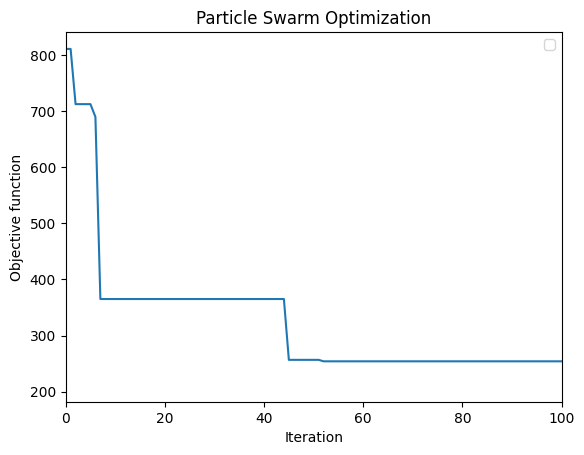

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: R$ 211,89
Tempo de Convergência para a segunda etapa: 1.2722110748291016 segundos


In [4213]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization')


# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

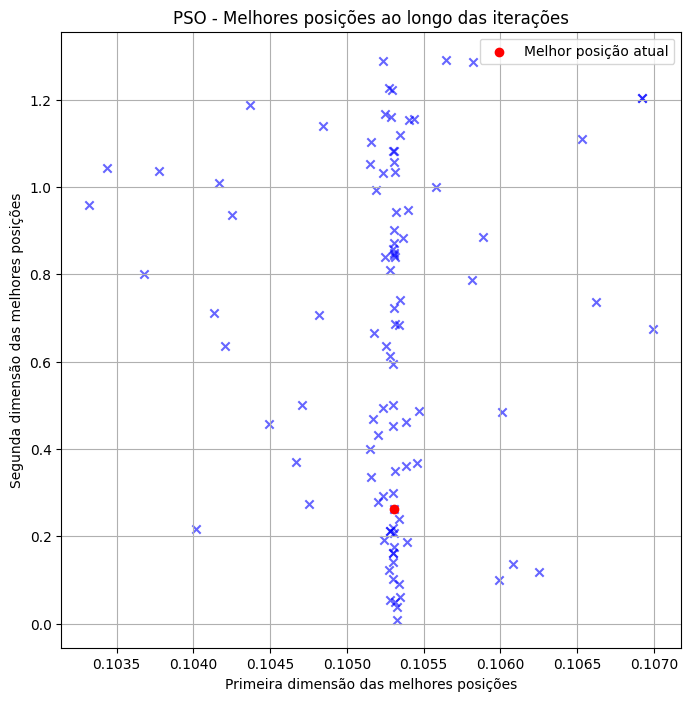

In [4214]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [4215]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [4216]:
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_quarto_cenario/melhor_custo_pso_quarto_cenario.csv


In [4217]:
# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [4218]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 211,89",1.272211,NaN


In [4219]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       1 non-null      int64  
 1   Melhor_Custo                1 non-null      object 
 2   Convergencia_Segunda_Etapa  1 non-null      float64
 3   Ciclos_MP                   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 160.0+ bytes


In [4220]:
resultado.describe()

,Index,Convergencia_Segunda_Etapa,Ciclos_MP
count,1.0,1.000000,0.0
mean,1.0,1.272211,NaN
std,NaN,NaN,NaN
min,1.0,1.272211,NaN
25%,1.0,1.272211,NaN
50%,1.0,1.272211,NaN
75%,1.0,1.272211,NaN
max,1.0,1.272211,NaN


In [4222]:
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [ ]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [ ]:
# # Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(convergencia):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [4224]:
# Arrays de tempos e severidade
Tempos = [
[[303]],
[[336]],
[[272]],
[[62]],
[[517]],
[[364]],
[[332]],
[[360]],
[[395]],
[[303]],
]

severidade = [
    [[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [4225]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,[303],[0.5]
1,[336],[0.5]
2,[272],[0.5]
3,[62],[0.5]
4,[517],[0.5]
5,[364],[0.5]
6,[332],[0.5]
7,[360],[0.5]
8,[395],[0.5]
9,[303],[0.5]


In [4226]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [4227]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,9,1
top,[303],[0.5]
freq,2,10
